# Can we predict when someone is home?

Using the data we will in the report try to predict if someone is home using machinelearning. We will first start here with reading the data.

In [46]:
import sys
import os
import warnings

# Hide warnings
sys.path.append('../')  # Add the parent directory to the system path


from tools.home_messages_db  import *
# db_url = 'sqlite:///myhome.db'
db_url = f'sqlite:///{os.path.join(os.path.dirname(os.getcwd()), "myhome.db")}'

db = home_messages_db(url = db_url)


In [47]:
device_data = db.query_df(""" 
SELECT
  messages.time, messages.attribute, messages.value, Unitcap.capability, Unitcap.unit, Devices.label, Devices.location
FROM messages
JOIN Devices
  ON messages.device_id = Devices.device_id
JOIN Unitcap
  ON messages.attribute = Unitcap.attribute
""")

# Data investigation

Lets take first a look at the data and the values we have.  We can see in the unique locations that there are sensors inside and outside the house. We can also see in capability what kind of device it is, interesting enough there are motionsensors and lightswitches.


In [48]:
device_data.head()

,time,attribute,value,capability,unit,label,location
0,1665346388,switch,off,switch,None,Light: flower,bathroom
1,1665346402,switch,on,switch,None,Light: flower,bathroom
2,1665347032,switch,off,switch,None,Light: flower,bathroom
3,1665347091,switch,on,switch,None,Light: flower,bathroom
4,1665349812,switch,off,switch,None,Light: flower,bathroom


In [49]:
import numpy as np

np.unique(device_data.location)

array(['bathroom', 'blue room', 'garden', 'gray room', 'green room',
       'kitchen', 'living room', 'roof'], dtype=object)

In [50]:
np.unique(device_data.capability)

array(['accelerationSensor', 'button', 'colorControl', 'colorTemperature',
       'contactSensor', 'energyMeter', 'illuminanceMeasurement',
       'motionSensor', 'powerMeter', 'relativeHumidityMeasurement',
       'signalStrength', 'switch', 'switchLevel', 'tamperAlert',
       'temperatureMeasurement', 'ultravioletIndex', 'voltageMeasurement',
       'winterdictionary35590.cube'], dtype=object)

## Data cleaning

Before we can interpret our results we will try to clean the data. We will perform the following cleaning:

- convert datatime to interpratible datetime
- Add the weekday
- Remove the devices outside of the home (roof and garden)
- Only focuss on motionsensors, controllsensor, and lightswitches


In [51]:
import datetime

device_data.time = device_data.time.apply(lambda x : datetime.datetime.fromtimestamp(int(x)))
device_data.index = device_data.time
device_data = device_data.drop(columns="time")

In [52]:
device_data['Weekday'] = device_data.index.map(lambda x : pd.Timestamp(x).day_name())

In [53]:
locations_inside = ["bathroom", "blue room", "gray room", "green room", "kitchen", "living room"]
device_data = device_data.loc[device_data.location.isin(locations_inside), :]

In [54]:
devices = ["contactSensor", "motionSensor", "switch"]
device_data = device_data.loc[device_data.capability.isin(devices), :]

# Data investigation
We will now look at our remaining data and see if there are patterns we could use. To do this we will look at the 10th of october 2022 and 10th of november

In [57]:
day_pattern_1010 = device_data.loc[device_data.index.strftime('%Y-%m-%d') == "2022-10-10", :]
day_pattern_1110 = device_data.loc[device_data.index.strftime('%Y-%m-%d') == "2022-11-10", :]

In [58]:
print(f"10 october: {np.unique(day_pattern_1010.capability)}")
print(f"10 november: {np.unique(day_pattern_1110.capability)}")

10 october: ['switch']
10 november: ['motionSensor' 'switch']


The first interesting thing is that the sensors are not there on everyday. So we have to rely mainly on the switch. Looking more into depth in this we can see that the motion sensor is installed on the 14th of october and the motion sensor on the 4 of december. We will thus filter the data to go past the 4th of december.

In [61]:
fd_contact = device_data.loc[device_data.capability == "contactSensor"].head(1).index
fd_motion = device_data.loc[device_data.capability == "motionSensor"].head(1).index

print(f"Contact sensor: {fd_contact}")
print(f"Motion sensor: {fd_motion}")

Contact sensor: DatetimeIndex(['2022-12-02 10:09:56'], dtype='datetime64[ns]', name='time', freq=None)
Motion sensor: DatetimeIndex(['2022-10-14 12:10:09'], dtype='datetime64[ns]', name='time', freq=None)


In [63]:
from datetime import datetime

device_data = device_data.loc[device_data.index >= datetime.strptime("12-4-2022", '%m-%d-%Y'), :]

We will now plot a day, 10 december and for each sensor we will plot the time and with color if they are on/ off or active inactive

In [64]:
day_pattern_1210 = device_data.loc[device_data.index.strftime('%Y-%m-%d') == "2022-12-10", :]

Text(0.5, 1.0, 'Motion sensor')

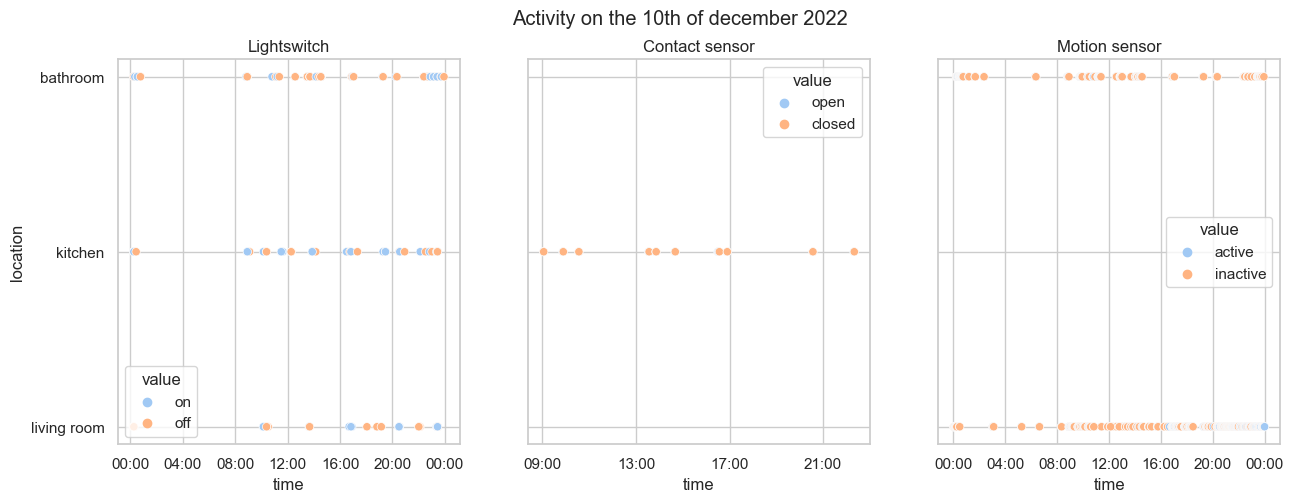

In [65]:
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates

sb.set_theme(style="whitegrid", palette="pastel")
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Activity on the 10th of december 2022')

# Plot switches
ax_switch = sb.scatterplot(x="time", y="location",
              hue="value",
              data=day_pattern_1210.loc[day_pattern_1210.capability == "switch",:],
              ax = axs[0]
)
ax_switch.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax_switch.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Plot contact sensor
ax_contact = sb.scatterplot(x="time", y="location",
              hue="value",
              data=day_pattern_1210.loc[day_pattern_1210.capability == "contactSensor",:],
              ax = axs[1]
)
ax_contact.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax_contact.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


# Plot Motionsensor
ax_motion = sb.scatterplot(x="time", y="location",
              hue="value",
              data=day_pattern_1210.loc[day_pattern_1210.capability == "motionSensor",:],
              ax = axs[2]
)
ax_motion.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax_motion.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add titles
axs[0].set_title("Lightswitch")
axs[1].set_title("Contact sensor")
axs[2].set_title("Motion sensor")

This plot shows quit clearly that lightswitch is the best indicator for when the day starts and ends. However, it does not show clear pattern if someone is home. The motion sensor seems to better for this purpose. 

## Prediction

For prediction we will first need to clean the dataset. Than we will run a gaussian mixture model and spectral clustering to see if we can see pattern. 

In [ ]:
# 4the of december till 18th of april
device_data
device_data_model.iloc[2].switch = True

C:\Users\remco\AppData\Local\Temp\ipykernel_62344\3592918843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_data_model.iloc[2].switch = True


In [66]:
device_data_model = pd.DataFrame()
device_data_model.index = pd.date_range('2022-12-4', '2023-04-8', freq='30min')
device_data_model["switch"] = False
device_data_model["contact_sensor"] = False
device_data_model["motion_sensor"] = False


for i in range(1, len(device_data_model.index)):
    mask = (device_data.index > device_data.index[i-1]) & (device_data.index <= device_data.index[i])
    # First check if light switch is on
    if device_data.loc[mask, "value"].str.contains("on").any():
        device_data_model["switch"].iloc[i] = True
    if device_data.loc[mask, "value"].str.contains("open").any():
        device_data_model["contact_sensor"].iloc[i] = True
    if device_data.loc[mask, "value"].str.contains("active").any():
        device_data_model["motion_sensor"].iloc[i] = True

In [67]:
device_data_model['Weekday'] = device_data_model.index.map(lambda x : pd.Timestamp(x).day_name())

,switch,contact_sensor,motion_sensor,Weekday
2022-12-04 00:00:00,False,False,False,Sunday
2022-12-04 00:30:00,False,False,False,Sunday
2022-12-04 01:00:00,True,False,True,Sunday
2022-12-04 01:30:00,True,False,True,Sunday
2022-12-04 02:00:00,True,False,True,Sunday
...,...,...,...,...
2023-04-07 22:00:00,False,True,True,Friday
2023-04-07 22:30:00,True,False,False,Friday
2023-04-07 23:00:00,False,False,False,Friday
2023-04-07 23:30:00,True,True,True,Friday


In [172]:
device_data_model_mo = device_data_model.loc[device_data_model.Weekday == "Monday", ["switch", "contact_sensor", "motion_sensor"]]

# For the train test split we will use till february to train and from febuary onward to test
# This is not random but since we need full days it is our best option
mask = device_data_model_mo.index < datetime.strptime("03-1-2023", '%m-%d-%Y')
X_train = device_data_model_mo.loc[mask, :]
X_test = device_data_model_mo.loc[~mask, :]

In [178]:
from sklearn.mixture import GaussianMixture

device_data_model_mo = device_data_model.loc[device_data_model.Weekday == "Monday", ["switch", "contact_sensor", "motion_sensor"]]

# For the train test split we will use till february to train and from febuary onward to test
# This is not random but since we need full days it is our best option
mask = device_data_model_mo.index < datetime.strptime("03-1-2023", '%m-%d-%Y')
X_train = device_data_model_mo.loc[mask, :]
X_test = device_data_model_mo.loc[~mask, :]

# Run the model
gm = GaussianMixture(n_components=2, random_state=0).fit(X_train)
X_test["active"] = gm.predict(X_test)


C:\Users\remco\AppData\Local\Temp\ipykernel_62344\3174699728.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["active"] = gm.predict(X_test)


In [176]:
# Make seperate plot function for further use
def plot_day(data, date, y, axes):
    ax = sb.scatterplot(y=y, x = data.loc[data.index.strftime('%Y-%m-%d') == date, :].index,
              data = data.loc[data.index.strftime('%Y-%m-%d') == date, :],
              ax = axs[axes]
    )
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

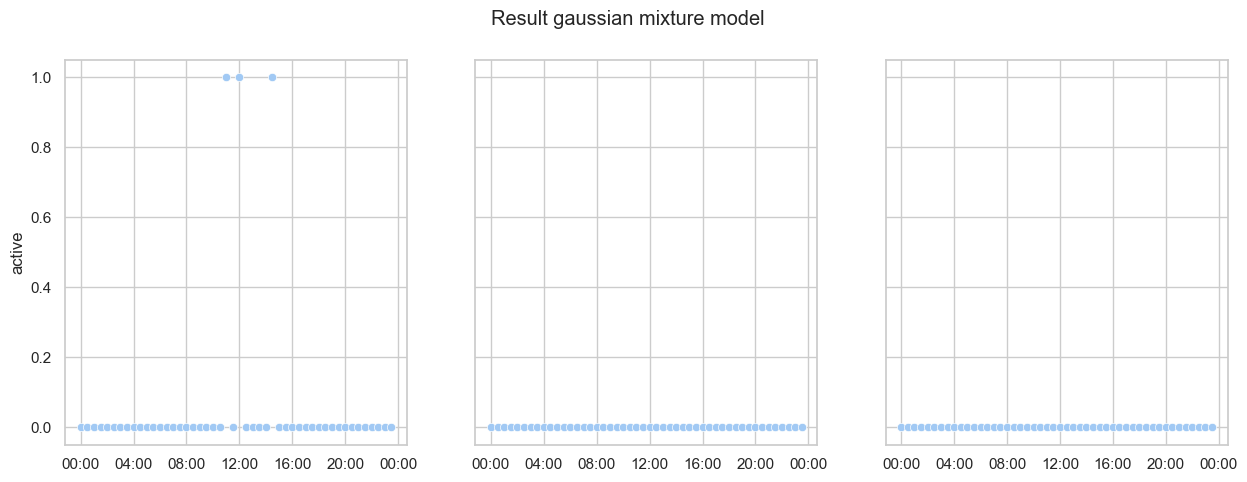

In [177]:
device_data.loc[device_data.index.strftime('%Y-%m-%d') == "2022-12-10", :]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Result gaussian mixture model')

# Plot oneday
plot_day(data = X_test, date = '2023-03-06', y="active", axes = 0)
plot_day(data = X_test, date = '2023-03-20', y="active", axes = 1)
plot_day(data = X_test, date = '2023-04-03', y="active", axes = 2)


A guassian mixture model does not seem to show any clear patterns in expectation with when someone will be inactive

In [197]:
from sklearn.cluster import SpectralClustering

device_data_model_mo = device_data_model.loc[device_data_model.Weekday == "Monday", ["switch", "contact_sensor", "motion_sensor"]]

# For the train test split we will use till february to train and from febuary onward to test
# This is not random but since we need full days it is our best option
mask = device_data_model_mo.index < datetime.strptime("03-1-2023", '%m-%d-%Y')
X_train = device_data_model_mo.loc[mask, :]
X_test = device_data_model_mo.loc[~mask, :]

# Run the model
clustering = SpectralClustering(n_clusters=2, assign_labels='discretize',random_state=0).fit(X_train)
X_test["active"] = clustering.fit_predict(X_test)


#X_test["active"] = 


C:\Users\remco\AppData\Local\Temp\ipykernel_62344\156478979.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["active"] = clustering.fit_predict(X_test)


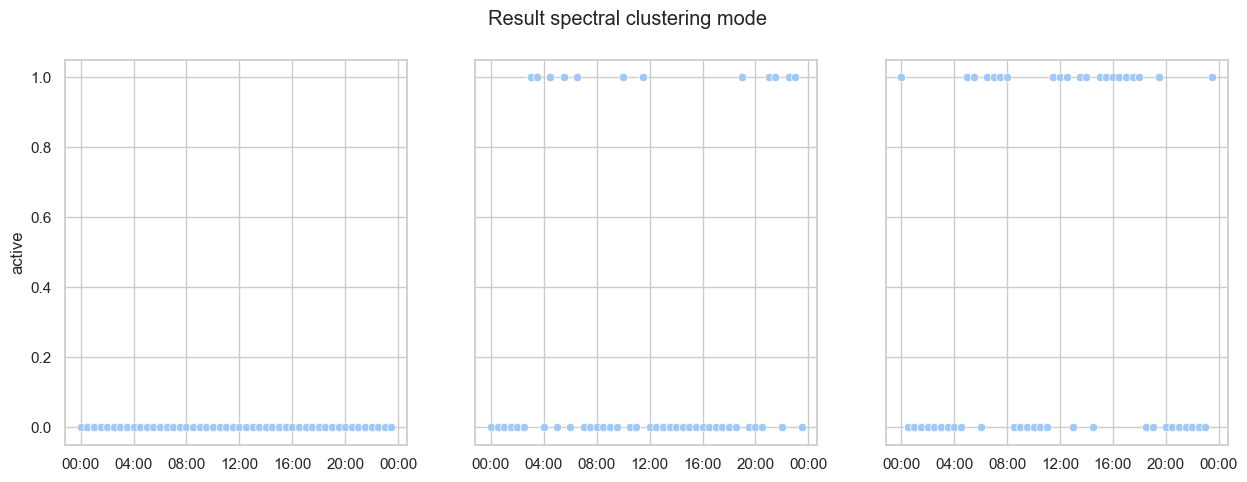

In [199]:
device_data.loc[device_data.index.strftime('%Y-%m-%d') == "2022-12-10", :]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Result spectral clustering model')

# Plot oneday
plot_day(data = X_test, date = '2023-03-06', y="active", axes = 0)
plot_day(data = X_test, date = '2023-03-20', y="active", axes = 1)
plot_day(data = X_test, date = '2023-04-03', y="active", axes = 2)


As can be seen above clustering methods do not predict behaviour correctly. However we have seen that the first time a lamp turns on and motionsensor show a general trend. We will thus further examing the statistics to see if there is a pattern. We will start with looking at the average time before and after 4.00 at the morning the light goes first out and on in the bedroom to see the average bedtime for each day. 

In [304]:
import datetime as dt
from datetime import datetime as datetime

# Create dataframe
device2day = pd.DataFrame()
device2day.index = pd.date_range('2022-12-4', '2023-04-8', freq='1D')
device2day["light_on"] = datetime.strptime("01:00:00", '%H:%M:%S')
device2day["light_off"] = datetime.strptime("01:00:00", '%H:%M:%S')

# Get for each day the two times
for day in device2day.index:
    next_day = day + dt.timedelta(days = 1)

    mask = (device_data.index >= day.replace(hour=4)) & (device_data.index < next_day.replace(hour=4))

    if len(device_data.loc[mask & (device_data.value == "on")].index) != 0:
        device2day.loc[day, "light_on"] = min(device_data.loc[mask & (device_data.value == "on")].index)
    else:
        device2day.loc[day, "light_on"] = np.nan

    if len(device_data.loc[mask & (device_data.value == "off")].index) != 0:
        device2day.loc[day, "light_off"] = max(device_data.loc[mask & (device_data.value == "off")].index)
    else:
        device2day.loc[day, "light_off"] = np.nan






In [312]:
# Now show the light on and light off time filterd by weekday
from math import floor

device2day["weekday"] = device2day.index.map(lambda x : pd.Timestamp(x).day_name())
device2day["light_on_int"] = device2day["light_on"].apply(lambda x : x.hour + x.minute/60)
device2day["light_off_int"] = device2day["light_off"].apply(lambda x : x.hour + x.minute/60)

info_table = device2day.groupby("weekday", sort=False, dropna=True).mean().loc[:,["light_on_int", "light_off_int"]]
info_table["light_on_int"] = info_table["light_on_int"].apply(lambda x : f'{floor(x)}:{int((x-floor(x))*60)}')
info_table["light_off_int"] = info_table["light_off_int"].apply(lambda x : f'{floor(x)}:{int((x-floor(x))*60)}')
info_table


,light_on_int,light_off_int
weekday,,
Sunday,7:0,3:27
Monday,7:41,3:27
Tuesday,6:50,4:45
Wednesday,6:52,9:43
Thursday,6:42,7:2
Friday,6:27,2:34
Saturday,6:52,2:52


As can be seen in the table above this method is not perfect. Mainly the lights off is quit strange. 4 o clock in afternoon or 7 o clock onn average is not verry likely. However the times the light go on could be realistic. It is all around 7 in the morning.